# Step 1: Load & Explore the Dataset

In [7]:
import pandas as pd

# Load as CSV
df = pd.read_csv('datatest.txt')

# Save as proper CSV
df.to_csv('dataset.csv', index=False)


In [8]:
import pandas as pd

# Load as CSV
df = pd.read_csv('datatest2.txt')

# Save as proper CSV
df.to_csv('dataset1.csv', index=False)


In [9]:
import pandas as pd

# Load the dataset (replace with your file path if different)
df = pd.read_csv("dataset.csv")

# Show first few rows
print("First 5 rows:")
display(df.head())

# Check for missing values
print("\n Missing values in each column:")
display(df.isnull().sum())

# Display data types and basic info
print("\n Dataset info:")
display(df.info())


First 5 rows:


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1



 Missing values in each column:


date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 145.9+ KB


None

# Step 2: Clean and Normalize the Data

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Optional: Drop 'date' column if you don't need it for modeling
df_cleaned = df.drop(columns=['date'])

# Check if all columns are numeric (just to be sure)
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Drop any rows with missing values (if any)
df_cleaned = df_cleaned.dropna()

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Show the scaled data
print(" Scaled Data Preview:")
display(df_scaled.head())

# Save the cleaned and scaled data
df_scaled.to_csv("dataset_scaled.csv", index=False)


 Scaled Data Preview:


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,0.831683,0.445132,0.344793,0.330033,0.704212,1.0
1,0.835960,0.447053,0.340787,0.341523,0.708308,1.0
2,0.838812,0.440651,0.337409,0.351030,0.704689,1.0
3,0.837030,0.429448,0.290912,0.356245,0.694383,1.0
4,0.844515,0.437450,0.287877,0.360605,0.705384,1.0


# Step 3: Build a Custom Gym Environment

In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class HVACEnv(gym.Env):
    def __init__(self, data):
        super(HVACEnv, self).__init__()

        self.data = data.values
        self.total_steps = len(self.data)
        self.current_step = 0

        # Observation space: 5 features (excluding occupancy)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

        # Action space: 0 = HVAC OFF, 1 = HVAC ON
        self.action_space = spaces.Discrete(2)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        obs = self.data[self.current_step, :-1].astype(np.float32)
        info = {}
        return np.array(obs, dtype=np.float32), info

    def step(self, action):
        current_data = self.data[self.current_step]
        occupancy = current_data[-1]

        # Reward logic
        if action == 1:
            reward = 1 if occupancy == 1 else -1
        else:
            reward = 0 if occupancy == 0 else -1

        self.current_step += 1
        terminated = self.current_step >= self.total_steps - 1
        truncated = False  # Optional: Add logic for time truncation if needed

        next_obs = self.data[self.current_step, :-1].astype(np.float32)
        return np.array(next_obs, dtype=np.float32), reward, terminated, truncated, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}")
        print(f"Data: {self.data[self.current_step]}")
        print("-" * 10)


In [17]:
env = HVACEnv(df_scaled)
obs = env.reset()
print("Initial Observation:", obs)


Initial Observation: (array([0.83168316, 0.44513205, 0.34479305, 0.33003333, 0.70421195],
      dtype=float32), {})


# Step 4: Train an RL Model Using PPO

- Step 4.1: Install dependencies

In [18]:
! pip install stable-baselines3[extra] gym


# Step 4.2: Wrap environment for training

In [19]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Check if environment follows Gym API correctly
check_env(HVACEnv(df_scaled), warn=True)

# Create a new environment instance
train_env = HVACEnv(df_scaled)


# Step 4.3: Train the PPO agent

In [20]:
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=10000)  # You can increase for better training


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2821 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.66e+03    |
|    ep_rew_mean          | -772        |
| time/                   |             |
|    fps                  | 1790        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007001367 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.054       |
|    learning_rate        | 0.0003      |
|    loss               

In [21]:
model.save("ppo_hvac_model")


In [34]:
model = PPO.load("ppo_hvac_model", env=HVACEnv(df_scaled))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Step 5: Evaluate the Agent’s Performance

In [35]:
from stable_baselines3 import PPO

# If not already trained:
# model = PPO("MlpPolicy", HVACEnv(df_scaled), verbose=1)
# model.learn(total_timesteps=10000)

# Load model if saved before
# model = PPO.load("ppo_hvac_model")

# Create environment
eval_env = HVACEnv(df_scaled)

obs, _ = eval_env.reset()
done = False
total_reward = 0

print("\n Agent Evaluation:")
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    done = terminated or truncated
    total_reward += reward
    print(f"Action taken: {action}, Reward: {reward}")

print(f"\n Total reward collected by PPO agent: {total_reward}")
print("Evaluation complete!")



 Agent Evaluation:
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action t

In [24]:
import pandas as pd

eval_env = HVACEnv(df_scaled)
obs, _ = eval_env.reset()
done = False
step = 0
total_reward = 0

# Log list
log_data = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    done = terminated or truncated
    total_reward += reward

    # Log each step
    log_data.append({
        "Step": step,
        "Temperature": obs[0],
        "Humidity": obs[1],
        "Light": obs[2],
        "CO2": obs[3],
        "HumidityRatio": obs[4],
        "Action": action,
        "Reward": reward
    })
    step += 1

# Convert to DataFrame
df_log = pd.DataFrame(log_data)

# Save to CSV
df_log.to_csv("ppo_agent_log.csv", index=False)

print(" Agent evaluation log saved to: ppo_agent_log.csv")
print(f" Total cumulative reward: {total_reward}")
print("Evaluation complete!")

 Agent evaluation log saved to: ppo_agent_log.csv
 Total cumulative reward: 823
Evaluation complete!


In [36]:
df_log["Baseline_Action"] = df_scaled.iloc[:len(df_log), -1].apply(lambda occ: 1 if occ == 1 else 0)
print("PPO ON:", df_log["Action"].sum())
print("Rule-Based ON:", df_log["Baseline_Action"].sum())
print("PPO OFF:", len(df_log) - df_log["Action"].sum())
print("Rule-Based OFF:", len(df_log) - df_log["Baseline_Action"].sum())


PPO ON: 1116
Rule-Based ON: 971
PPO OFF: 1548
Rule-Based OFF: 1693


In [37]:
ppo_energy = df_log["Action"].sum()
baseline_energy = df_log["Baseline_Action"].sum()
saving_percent = (baseline_energy - ppo_energy) / baseline_energy * 100
print(f"Energy Saved by PPO: {saving_percent:.2f}%")


Energy Saved by PPO: -14.93%


# STEP 6: Visualization & Reporting

In [25]:
! pip install matplotlib


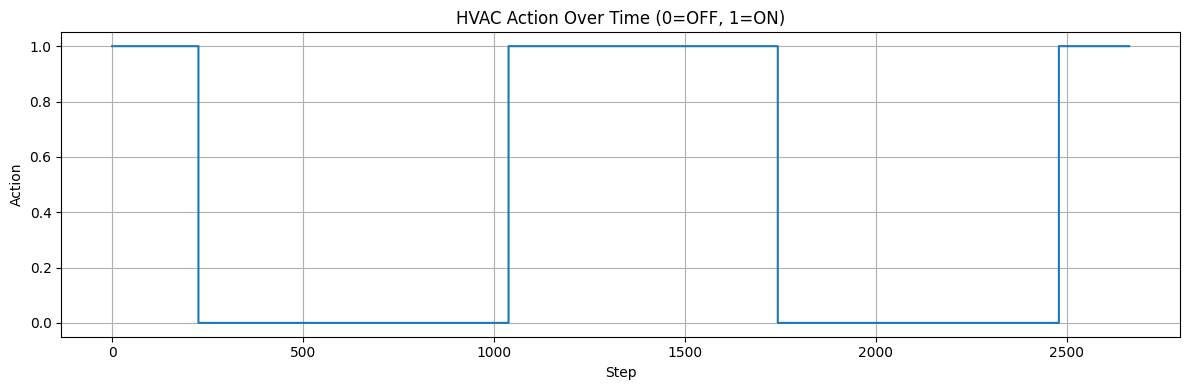

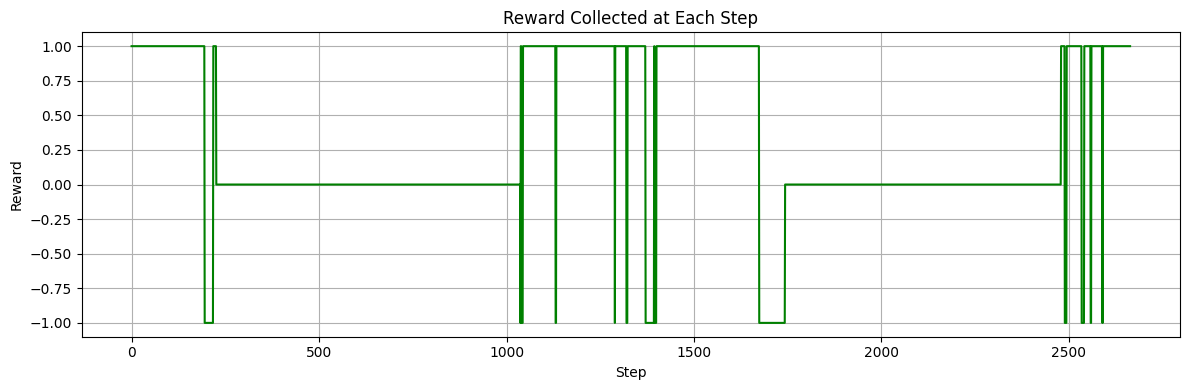

In [26]:
import matplotlib.pyplot as plt

# Plot HVAC Action Over Time
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Action"], drawstyle='steps-post')
plt.title("HVAC Action Over Time (0=OFF, 1=ON)")
plt.xlabel("Step")
plt.ylabel("Action")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Over Time
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Reward"], color='green')
plt.title("Reward Collected at Each Step")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the agent log
df_log = pd.read_csv("ppo_agent_log.csv")


# Plot 2 – PPO vs. Rule-Based Comparison

🤖 PPO Agent - Total HVAC ON steps: 1116
📏 Rule-Based - Total HVAC ON steps: 971
💡 Energy Saved by PPO: -14.93%


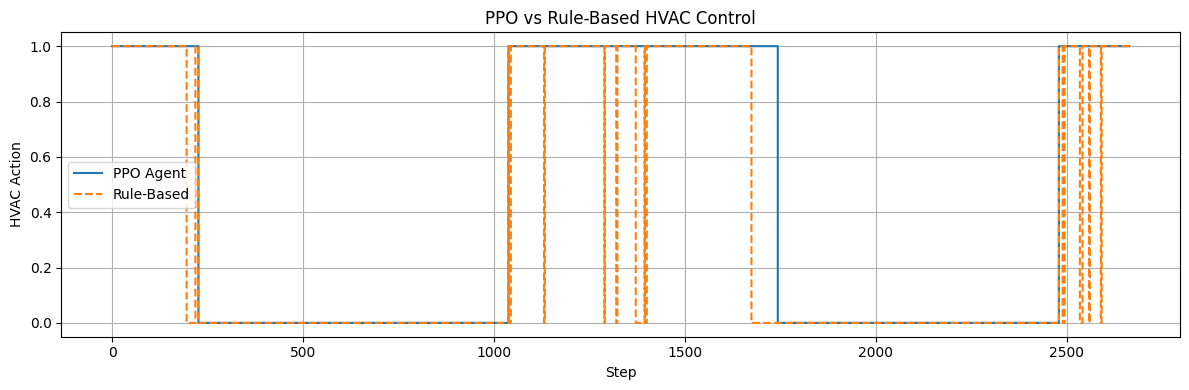

In [ ]:
# --- Baseline Rule: Turn HVAC ON only when occupancy == 1 ---
# Using the original occupancy column from scaled data
df_log["Baseline_Action"] = df_scaled.iloc[:len(df_log), -1].apply(lambda occ: 1 if occ == 1 else 0)

# --- Compare Total HVAC Usage ---
ppo_on = df_log["Action"].sum()
baseline_on = df_log["Baseline_Action"].sum()

print(f"🤖 PPO Agent - Total HVAC ON steps: {ppo_on}")
print(f"📏 Rule-Based - Total HVAC ON steps: {baseline_on}")

# --- Energy Savings ---
if baseline_on > 0:
    savings = (baseline_on - ppo_on) / baseline_on * 100
    print(f" Energy Saved by PPO: {savings:.2f}%")
else:
    print(" Baseline HVAC usage is zero, cannot calculate savings.")

# --- Plot Comparison ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Action"], label="PPO Agent", drawstyle="steps-post")
plt.plot(df_log["Step"], df_log["Baseline_Action"], label="Rule-Based", linestyle="--", drawstyle="steps-post")
plt.title("PPO vs Rule-Based HVAC Control")
plt.xlabel("Step")
plt.ylabel("HVAC Action")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot 3 – Energy Savings Comparison

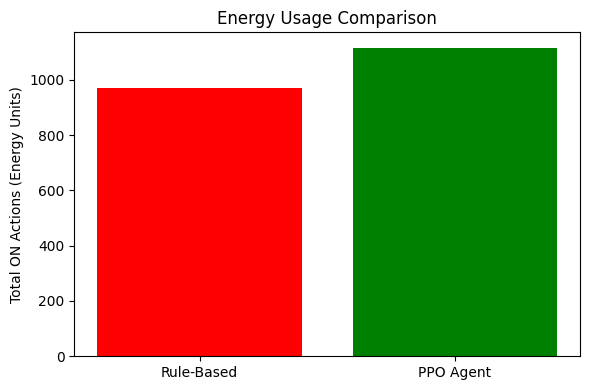

 Energy saved by PPO: -14.93%
Evaluation complete!


In [31]:
ppo_energy = df_log["Action"].sum()
baseline_energy = df_log["Baseline_Action"].sum()
saving = (baseline_energy - ppo_energy) / baseline_energy * 100

# Bar chart comparison
plt.figure(figsize=(6, 4))
plt.bar(["Rule-Based", "PPO Agent"], [baseline_energy, ppo_energy], color=["red", "green"])
plt.title("Energy Usage Comparison")
plt.ylabel("Total ON Actions (Energy Units)")
plt.tight_layout()
plt.show()

print(f" Energy saved by PPO: {saving:.2f}%")
print("Evaluation complete!")


# Pie Chart – HVAC ON vs. OFF (PPO Agent)

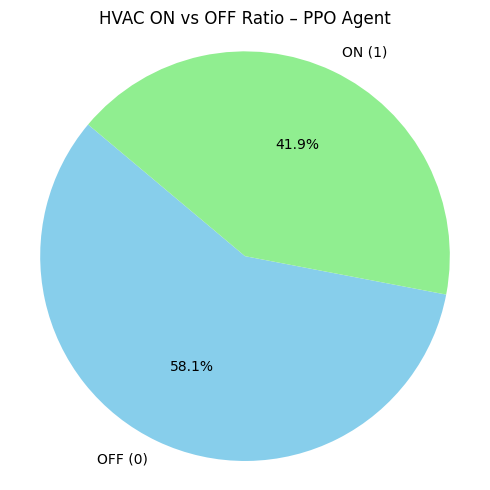

In [32]:
# Count ON vs OFF actions
action_counts = df_log["Action"].value_counts().sort_index()

labels = ["OFF (0)", "ON (1)"]
colors = ["skyblue", "lightgreen"]

plt.figure(figsize=(5, 5))
plt.pie(action_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("HVAC ON vs OFF Ratio – PPO Agent")
plt.axis("equal")
plt.tight_layout()
plt.show()


# Reward Over Time (PPO Agent)

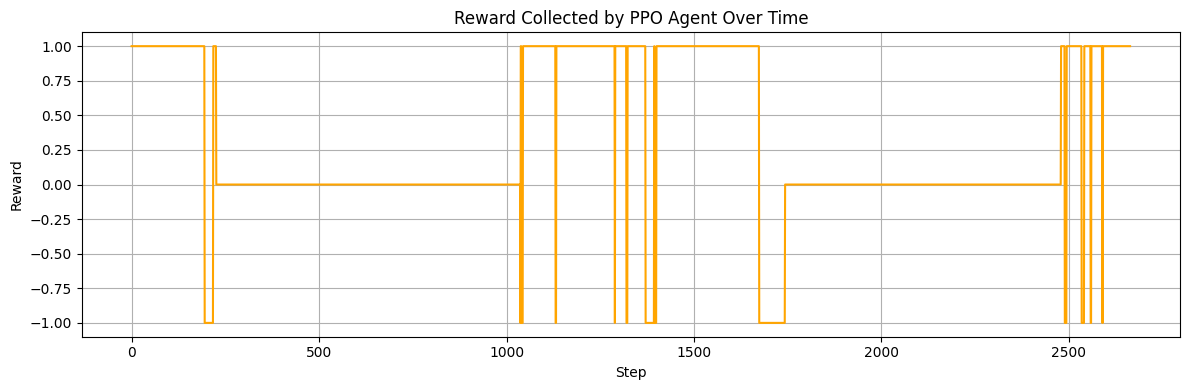

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Reward"], color="orange")
plt.title("Reward Collected by PPO Agent Over Time")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()
